<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF6804 Vision par ordinateur

Polytechnique Montréal

Author: Soufiane Lamghari




Description : This notebook implements Mask R-CNN for instance segmentation (and object detection) in inference, using ResNet50 as the backbone network (pre-trained on the 80 classes of MS COCO). In this example, we predict masks for some sample images.

Import libraries

In [1]:
import torchvision.models as models
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import urllib.request as request
import random
import cv2
from PIL import Image
from skimage import io

Get images (here from the github of INF6804 course) and transform them as torch tensors

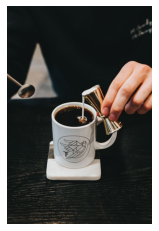

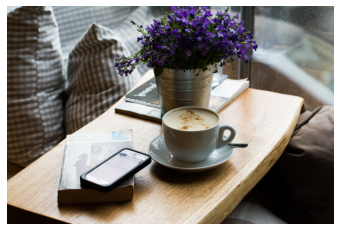

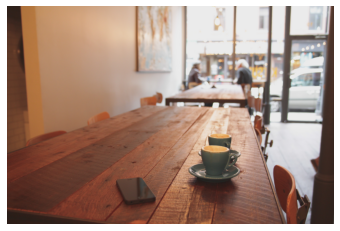

In [2]:
source = 'https://raw.githubusercontent.com/gabilodeau/INF6804/master/images'
examples = ['coffee0.jpg', 'coffee1.jpg', 'coffee2.jpg']

tensors = []
preprocess = transforms.Compose([transforms.ToTensor()])

for example in examples:
  img = io.imread(os.path.join(source, example))
  tensors.append(preprocess(img))
  plt.imshow(img); plt.axis('off'); plt.show()

Load labels (here from the github of INF6804 course)

In [3]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
  COCO_NAMES.append(label_name.strip().decode('UTF-8'))

Load the model and get the predictions, the backbone network is ResNet50 pre-trained on the 80 classes of MS COCO. 

In [4]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()
predictions = model(tensors)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


Showing examples of predicted masks, one example (with the highest score) from each image

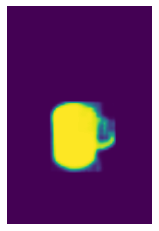

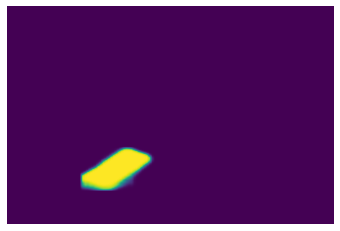

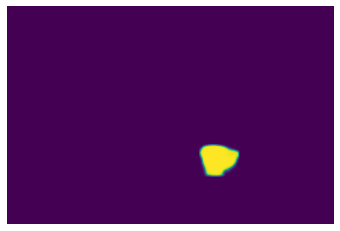

In [5]:
for prediction in predictions:
    mask = prediction['masks'][0][0].detach().numpy()

    plt.imshow(mask); plt.axis('off'); plt.show()

This function is used to draw the predicted masks over the RGB source images

In [6]:
def draw_colored_masks(image):
  name_colors=list(mcolors.CSS4_COLORS.keys())
  name_colors.remove('black')
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  rgb_color = rgb_colors[random.randrange(0,len(rgb_colors))]
  r[image > 0.5], g[image > 0.5], b[image > 0.5] = rgb_color
  colored_mask = np.stack([r, g, b], axis=2)
  return colored_mask, rgb_color

The threshold helps to decide if a prediction is enough good to be considered. This can be changed depending on your preference

In [7]:
THRESHOLD = 0.95

Display predictions on images. A prediction includes a mask, a bounding box, a class label and a confidence score. Here we show only predictions with a score higher than the threshold (0.95)

nbobjects (over threshold):  2


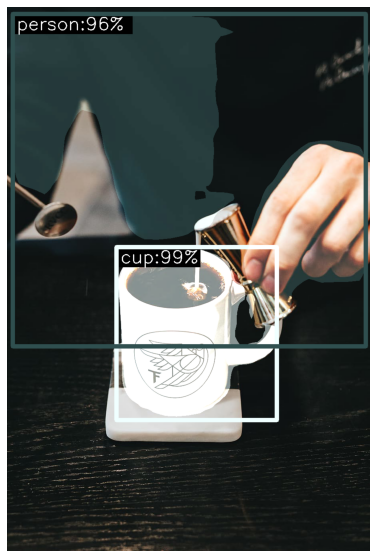

nbobjects (over threshold):  5


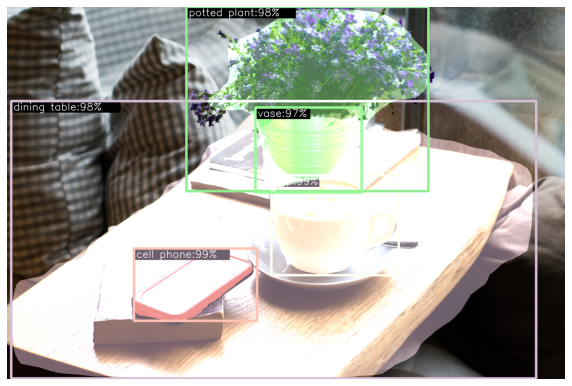

nbobjects (over threshold):  7


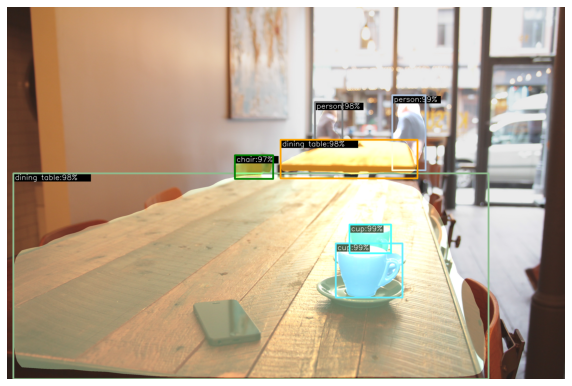

In [26]:
for i, prediction in enumerate(predictions):
  img = tensors[i].permute(1,2,0).mul(255).byte().numpy() # permute est equivalent a faire deux tranpose : ici permute(1,2,0) peut etre remplacee par transpose(0, 1).transpose(1, 2)

  nb_objects=0
  for j, score in enumerate(prediction['scores']):
      if score >= THRESHOLD:
        
        mask = prediction['masks'][j][0].detach().numpy()
        colored_mask, color = draw_colored_masks(mask)
        label=prediction['labels'][j]
        x1,y1,x2,y2 = prediction['boxes'][j]
        

        img = cv2.addWeighted(img, 1, colored_mask, 0.5, 0)
        label_score=COCO_NAMES[label]+':{}%'.format(str(int(score.item()*100)))
        img = cv2.rectangle(img, (x1+5, y1+5), (x1+len(label_score)*30, y1+50), (0,0,0), -1)
        img = cv2.putText(img, label_score, (x1+10, y1+40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color.tolist(), 10)
        

        nb_objects+=1

  print('nbobjects (over threshold): ', nb_objects)

  plt.figure(figsize = (10,10))
  plt.imshow(img); plt.axis('off'); plt.show()

**References:**
 - https://pytorch.org/docs/stable/torchvision/models.html

 - [Mask R-CNN paper](https://arxiv.org/abs/1703.06870)